
=== 🔍 Analyse des corrélations hebdomadaires ===
⚠️ Corrélation positive forte entre evaporation_lag_1w_pca_1 et water_flow_week2 : 0.03
⚠️ Corrélation positive forte entre evaporation_pca_1 et water_flow_week3 : 0.03
⚠️ Corrélation positive forte entre precipitations_lag_1w_pca_1 et water_flow_week1 : 0.11
⚠️ Corrélation négative forte entre precipitations_lag_1w_pca_1 et water_flow_week2 : -0.05
⚠️ Corrélation positive forte entre precipitations_lag_1w_pca_2 et water_flow_week1 : 0.05
⚠️ Corrélation positive forte entre precipitations_pca_1 et water_flow_week1 : 0.10
⚠️ Corrélation positive forte entre precipitations_pca_1 et water_flow_week2 : 0.11
⚠️ Corrélation négative forte entre precipitations_pca_1 et water_flow_week3 : -0.05
⚠️ Corrélation positive forte entre precipitations_pca_2 et water_flow_week2 : 0.05
⚠️ Corrélation positive forte entre snow_index et water_flow_week1 : 0.09
⚠️ Corrélation positive forte entre snow_index et water_flow_week2 : 0.06
⚠️ Corrélation négativ

C:\Users\chapu\AppData\Local\Temp\ipykernel_7356\3904683150.py:59: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chapu\AppData\Local\Temp\ipykernel_7356\3904683150.py:62: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig(f"correlation_outputs/correlation_heatmap{DATASET_SPEC}.png")
c:\Users\chapu\E.Lucas\Perso\Github\WaterScarcity.Hackathon\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


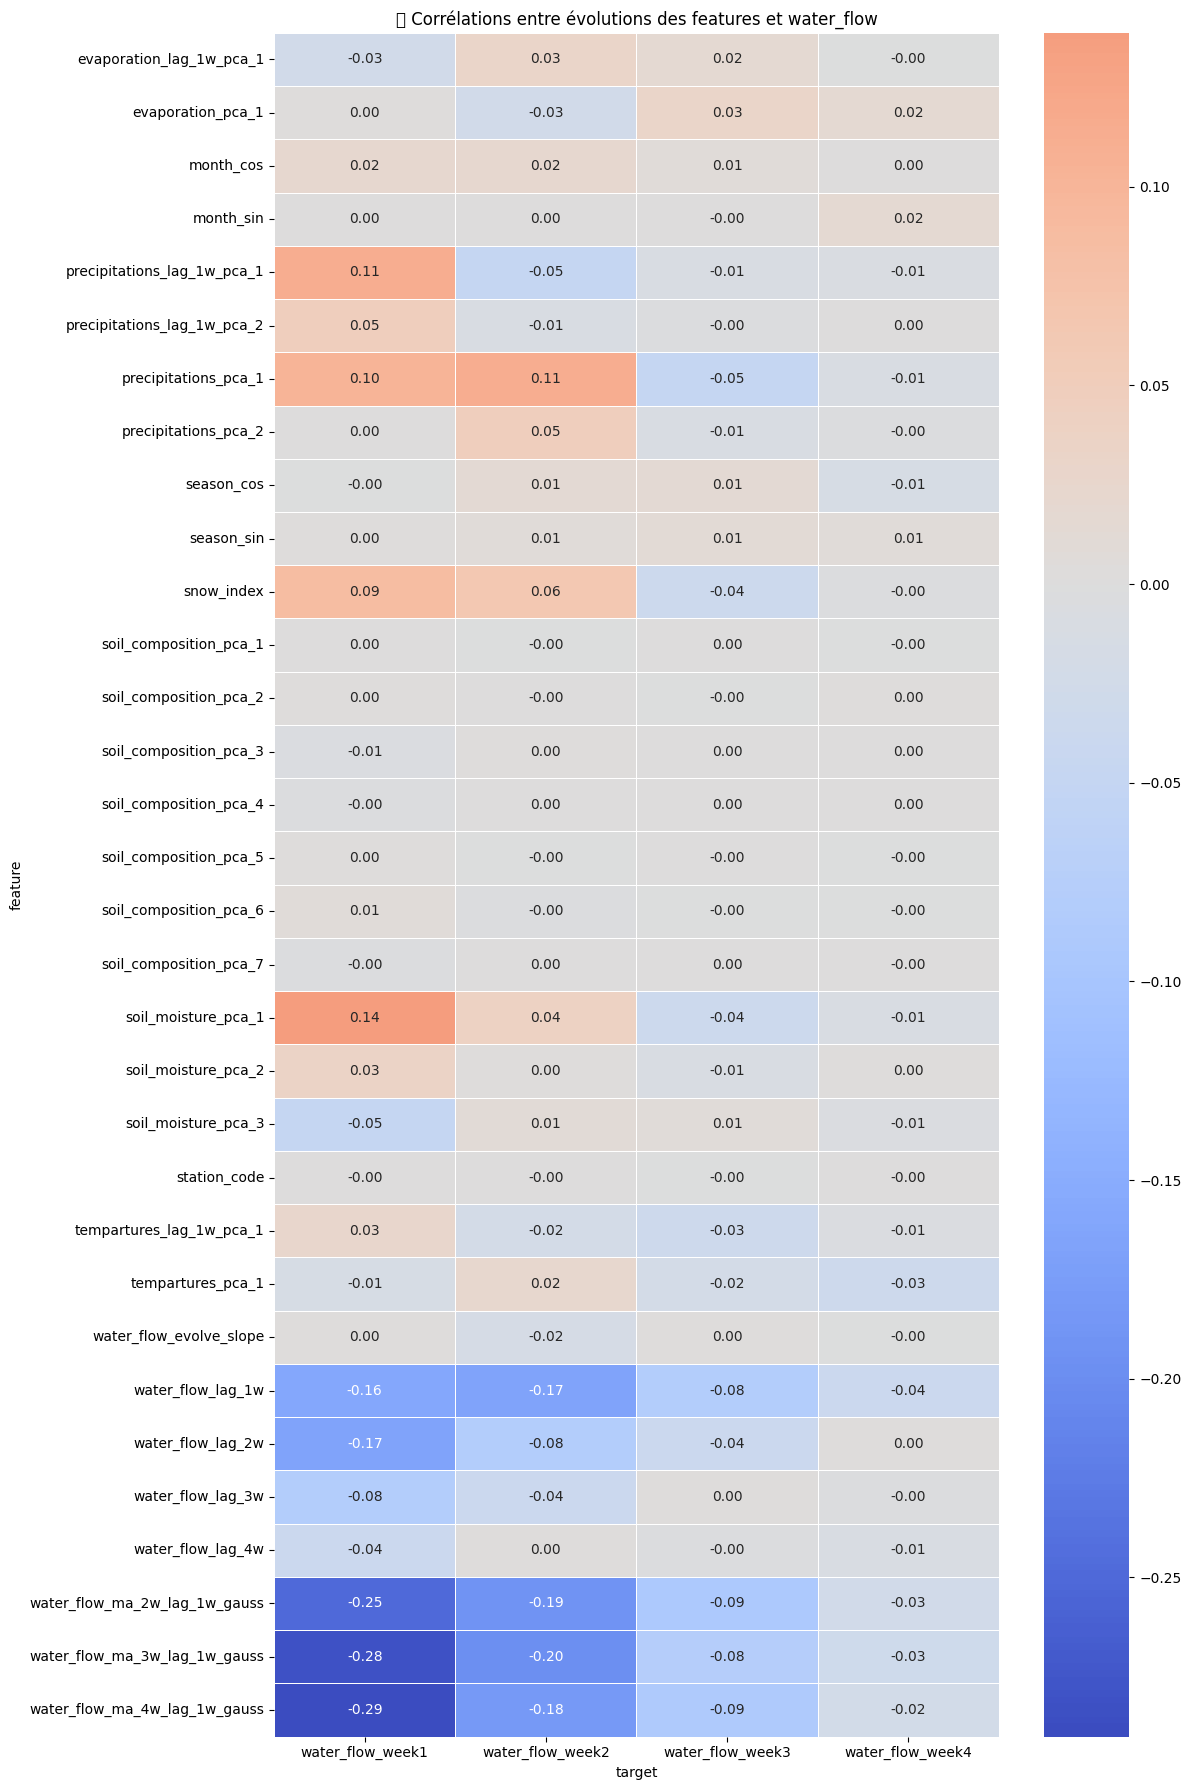

✅ Corrélations fortes sauvegardées dans : correlation_outputs/strong_correlations.json


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json

DATASET_SPEC = "dataset_custom_21"

dataset_train = pd.read_csv(f"../../../data/input/{DATASET_SPEC}.csv")
dataset_train = dataset_train.set_index("ObsDate")
dataset_train = dataset_train[dataset_train["north_hemisphere"] == 1]


# PARAMÈTRES
alert_threshold = 0.03
target_cols = ["water_flow_week1", "water_flow_week2", "water_flow_week3", "water_flow_week4"]
feature_cols = dataset_train.select_dtypes(include=[np.number]).columns.difference(target_cols)

# Préparation
df = dataset_train.sort_index()
df_diff = df.groupby("station_code").transform(lambda x: x.diff())
df_diff["station_code"] = df["station_code"]
df_diff.index = df.index

# Résultats
correlation_results = []
strong_correlations_by_target = {}

print("\n=== 🔍 Analyse des corrélations hebdomadaires ===")
for feature in feature_cols:
    for target in target_cols:
        subset = df_diff[[feature, target]].dropna()

        if subset[feature].std() == 0 or subset[target].std() == 0:
            continue

        corr = subset[feature].corr(subset[target])
        correlation_results.append({
            "feature": feature,
            "target": target,
            "correlation": corr
        })

        if abs(corr) >= alert_threshold:
            direction = "positive" if corr > 0 else "négative"
            print(f"⚠️ Corrélation {direction} forte entre {feature} et {target} : {corr:.2f}")
            strong_correlations_by_target.setdefault(target, []).append(
                feature
            )

# Heatmap
cor_df = pd.DataFrame(correlation_results)
pivot_cor = cor_df.pivot(index="feature", columns="target", values="correlation")

plt.figure(figsize=(12, len(pivot_cor) * 0.5 + 2))
sns.heatmap(pivot_cor, annot=True, center=0, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("🔥 Corrélations entre évolutions des features et water_flow")
plt.tight_layout()

os.makedirs("correlation_outputs", exist_ok=True)
plt.savefig(f"correlation_outputs/correlation_heatmap{DATASET_SPEC}.png")
plt.show()

# Sauvegarde JSON
with open(f"correlation_outputs/strong_correlations_{DATASET_SPEC}.json", "w") as f:
    json.dump(strong_correlations_by_target, f, indent=4, default=str)

print("✅ Corrélations fortes sauvegardées dans : correlation_outputs/strong_correlations.json")
